# Stich together monthly BC files

Script to stich together bias corrected files. After ESM bias correction by month, files are grouped by month (+/- 15 day buffer). This script removes the 15 day buffer and saves the output as yearly files. 

orginal by Ryan Currier, A.Smith, modified by Bert Kruyt March 2023


In [10]:
import xarray as xr
import dask
import glob
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import multiprocessing as mp
import time, calendar

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
# The path where the monthly output of the ESM bias correction was written to:
mon_BC_path = "/glade/scratch/bkruyt/CMIP6/monthly_BC_3D/"

# the path to the original (non-BC) monthly GCM:
raw_mon_path = "/glade/scratch/bkruyt/CMIP6/raw_month/"

# dir for merged output:
out_dir = '/glade/scratch/bkruyt/CMIP6/BC_3D_merged/'


modelLs=['MIROC-ES2L'] #['CESM2','CMCC-CM2-SR5','CNRM-ESM2-1','MIROC-ES2L']
scenarios= ['historical'] #['ssp370'] # ['ssp585' ] # ,  ['historical' , 'ssp585', 'ssp370']

# Add variable attributes back in? These have been 'lost' in bias-correction
add_attrs=True


## Verify time (optional)

Plot the input and output time variable for a specific month to see if they allign, and are discontinuous

The first plot should show a discontinuous blue line on top of a continuous red line


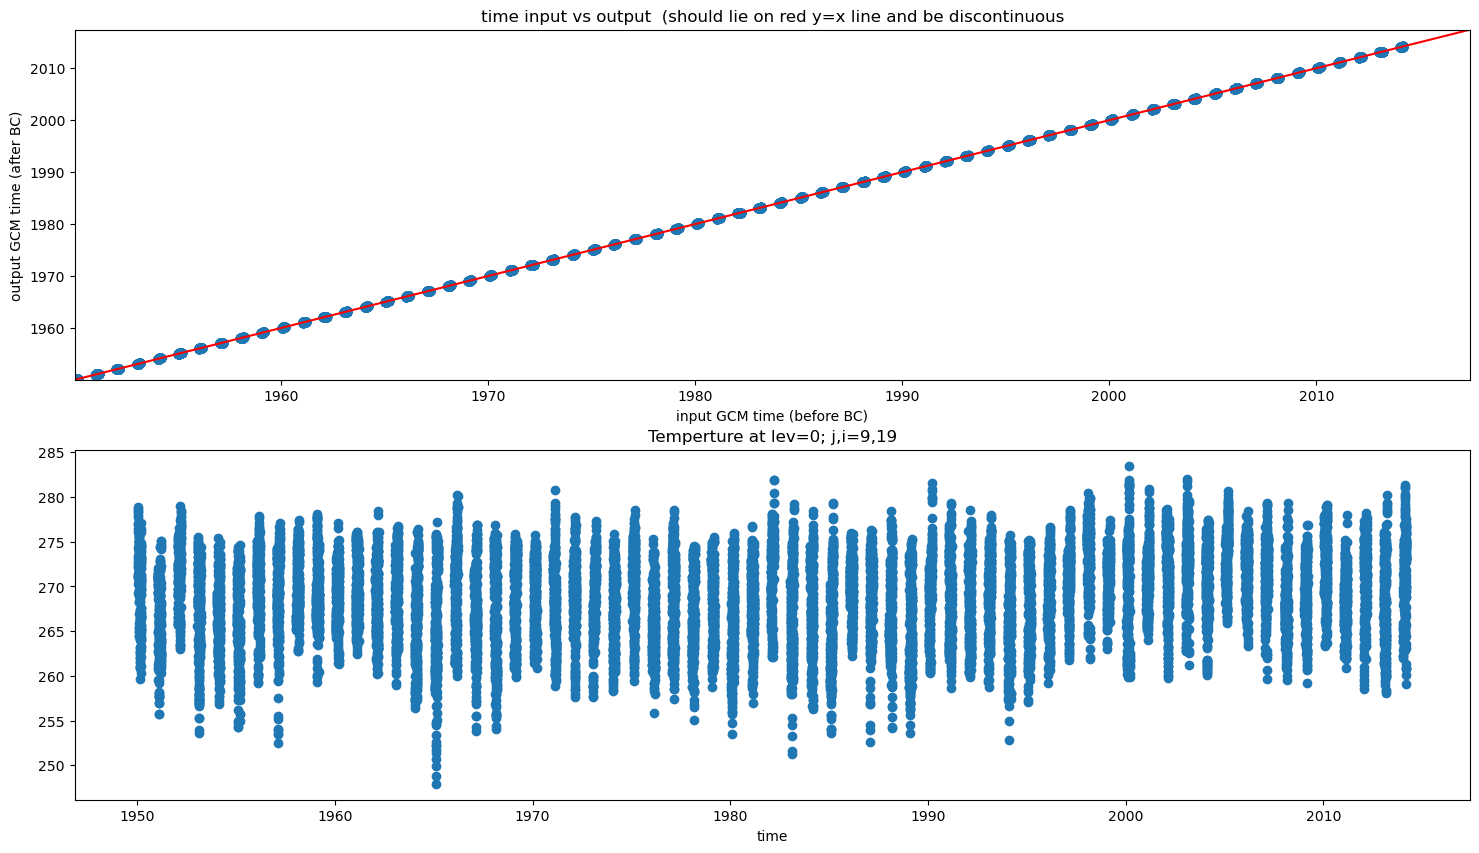

In [3]:
month=2

scen=scenarios[0]; mod=0 


dsRaw=xr.open_mfdataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+'_'+str(month).zfill(2)+".nc")
dsTmp=xr.open_mfdataset(mon_BC_path+modelLs[mod]+"/"+scen+'/'+"bias_corrected_*_"+str(month).zfill(2)+".nc")

fig, ax = plt.subplots(2,1, figsize=(18,10) )

ax[0].scatter(dsRaw.time.values[:], dsTmp.time.values[:])
ax[0].set_title('time input vs output  (should lie on red y=x line and be discontinuous')
ax[0].set_xlabel('input GCM time (before BC)')
ax[0].set_ylabel('output GCM time (after BC)')
ax[0].axline((dsRaw.time.dt.year.values[0], dsTmp.time.dt.year.values[0]), slope=1, color='red') # plot y=x line to validate
ax[0].set_ylim(dsTmp.time.values[0], None)
ax[0].set_xlim(dsRaw.time.values[0], None)

# Plot BC temp:
ax[1].scatter(dsTmp.time.values, dsTmp.T.values[:,0,9,19] )
ax[1].set_title('Temperture at lev=0; j,i=9,19')
ax[1].set_xlabel('time')
# ax[1].set_ylabel(dsTmp.T.units  ) #('Temp')

plt.show()

## Stitch files back together

### Serial version

stich monthly files back together

optionally add in the variable attributes that have been lost during Bias correction

In [11]:
%%time


for mod in range(len(modelLs)):
    for scen in scenarios:

        if not os.path.exists(out_dir + modelLs[mod]+'/'+scen):
                os.makedirs( out_dir + modelLs[mod]+'/'+scen )  

        print(modelLs[mod], scen)

        if scen == "historical":
            year_start = ['1950','1982']
            year_end = ['1981','2014']
        else:
            year_start = ['2015','2047','2079']
            year_end = ['2046','2078','2100']

        # load one original GCM file so we can put the variable attributes back:
        dsRaw=xr.open_dataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_01.nc")
        
        
        for t in range(1):
        # for t in range(len(year_start)):

            print(year_start[t], "-", year_end[t])
            ds_month={}

            for month in range(1,13):
                print('   month = '+str(month).zfill(2))
              
                # Load the bias corrected dataset
                dsBC=xr.open_mfdataset(mon_BC_path+modelLs[mod]+"/"+scen+'/'+"bias_corrected_"+
                                        year_start[t]+"-"+year_end[t]+"_"+str(month).zfill(2)+".nc")

                # OPTIONAL: put variable attributes back
                if add_attrs:
                    # print("   adding variable attributes back in" )
                    for var in dsBC.data_vars:
                        if var == 'z':
                            # dsBC[var].attrs = dsRaw['Z'].attrs # this is empty as well
                            dsBC.z.attrs['comment']="monthly values held constant over the month's duration."
                        elif var != 'z':
                            dsBC[var].attrs = dsRaw[var].attrs
                          
                        
                # Because the Fortran ESM code does not output the correct time, we overwrite with the original. 
                # I don't like this and ideally we should modify the fortran code to do the right thing.... (Has been modified)
                # dsGCMraw=xr.open_dataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_"+str(month).zfill(2)+".nc")
                # dsBC['time']=dsGCMraw['time'].sel(time=slice(start_time[t], end_time[t])) 

                dsGroup=dsBC.groupby(dsBC['time'].dt.month).groups

                # drop the buffer time periods +/- 15 days
                ds_month[str(month).zfill(2)]=dsBC.isel(time=dsGroup[month]) 
                
                #remove any possible duplicate values (and load - BK):
                ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(
                    time=~ds_month[str(month).zfill(2)].get_index("time").duplicated()).load() 
                
                # expand the z variable to include time (somehow the bc code removes the time component of z?)
                ds_month[str(month).zfill(2)]['z'] = ds_month[str(month).zfill(2)].z.expand_dims(time=len(ds_month[str(month).zfill(2)].time))
                # ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=slice(start_time[t],end_time[t])).drop('z') # slice and drop z variable - BK:why?
                
   
            # Merge months and save as yearly datasets (30 yr takes very long/large mem demand).
            # This could be modified to save an arbitrary amount of years per file
            print('   loaded datasets, now merge `em')
            for yr in range(int(year_start[t]), int(year_end[t])): # can we parallelize this?
                t1=time.time()

                # merge the 12 months of year 'yr' into one dataset:
                dsOut=xr.merge(
                    [ds_month[str(month).zfill(2)].sel(
                        time=ds_month[str(month).zfill(2)].time.dt.year==yr
                    ) for month in range(1,13)]
                )#.load()
                
                # Check if the years have the correct length: (this is not complete, if in doubt, check manually afterwards)
                if dsOut.time.dt.calendar=='noleap' and len(dsOut.time)!=1460:
                    print("   !!! "+str(yr)+" has length ", dsOut.time.shape, " while it should be 1460 ")
                elif dsOut.time.dt.calendar=='proleptic_gregorian':
                    if (not (calendar.isleap(np.unique(dsOut.time.dt.year))) and (len(dsOut.time)!=1460) ): # if not a leap year the length should be 1460
                         print("   !!! "+str(yr)+" has length ", dsOut.time.shape, " while it should ne 1460 ")
                    elif calendar.isleap(np.unique(dsOut.time.dt.year)) and (len(dsOut.time)!=1464): # if a leap year the length should be 1464
                          print("   !!! "+str(yr)+" has length ", dsOut.time.shape, " while it should ne 1464 ")
                    else: print('      merged year '+str(yr) ,' time: ', time.time()-t1)
                else:
                    print( "   calendar is ", dsOut.time.dt.calendar )

                
#                 if(len(dsOut.time)!=1460 and np.unique(dsOut.time.dt.year)[0]%4==0): print("   !!! dsOut.time: ",dsOut.time.shape, " in ",str(yr))
#                 elif np.unique(dsOut.time.dt.year)[0]%4==0: 
#                 else: print('      merged year '+str(yr) ,' time: ', time.time()-t1)
                
                t2= time.time()
                dsOut.to_netcdf(out_dir + modelLs[mod]+'/'+scen+'/'+modelLs[mod]+'_BC_'+str(yr)+'.nc',  
                                encoding={'time':{'units':"days since 1900-01-01"}}) 
                print('      saved year '+str(yr)+' to '+ out_dir + modelLs[mod]+'/'+modelLs[mod]+'_BC_'+str(yr)+'.nc' ,
                     'time:  ', time.time()-t2)

                # del dsOut         

            # del ds_month



MIROC-ES2L historical
1950 - 1981
   month = 01
   month = 02
   month = 03
   month = 04
   month = 05
   month = 06
   month = 07
   month = 08
   month = 09
   month = 10
   month = 11
   month = 12
   loaded datasets, now merge `em
   !!! 1950 has length  (1458,)  while it should ne 1460 
      saved year 1950 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/test/MIROC-ES2L/MIROC-ES2L_BC_1950.nc time:   2.911320924758911
      merged year 1951  time:  34.05494570732117
      saved year 1951 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/test/MIROC-ES2L/MIROC-ES2L_BC_1951.nc time:   0.6621823310852051
      merged year 1952  time:  37.464540004730225
      saved year 1952 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/test/MIROC-ES2L/MIROC-ES2L_BC_1952.nc time:   0.6539688110351562
      merged year 1953  time:  38.197856426239014
      saved year 1953 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/test/MIROC-ES2L/MIROC-ES2L_BC_1953.nc time:   0.7078320980072021
      merged year 1954  time:  35.

In [22]:
## RECOMBINE RAW to see if this has the same z issue


for mod in range(len(modelLs)):
    for scen in scenarios:

        if not os.path.exists(out_dir + modelLs[mod]+'/'+scen):
                os.makedirs( out_dir + modelLs[mod]+'/'+scen )  
 
        print(modelLs[mod], scen)

        if scen == "historical":
            year_start = ['1950','1982']
            year_end = ['1981','2014']
        else:
            year_start = ['2015','2047','2079']
            year_end = ['2046','2078','2100']

        # load one original GCM file so we can put the variable attributes back:
        dsGCMraw=xr.open_dataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_01.nc")
        
        
        
        for t in range(len(year_start)):
            print(year_start[t], "-", year_end[t])
            ds_month={}

            # for month in range(1,13):
            for month in range(1,4):  # for Testing only
                print('   month = '+str(month).zfill(2))
              
                # Load the bias corrected dataset
                # dsBC=xr.open_mfdataset(mon_BC_path+modelLs[mod]+"/"+scen+'/'+"bias_corrected_"+
                #                         year_start[t]+"-"+year_end[t]+"_"+str(month).zfill(2)+".nc")
                dsBC=xr.open_mfdataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_" +str(month).zfill(2)+".nc")

                # # OPTIONAL: put variable attributes back
                # if add_attrs:
                #     # print("   adding variable attributes back in" )
                #     for var in dsBC.data_vars:
                #         if var != 'z':
                #             dsBC[var].attrs = dsRaw[var].attrs
                #             # print(dsBC[var].attrs, '\n')
                        
                # Because the Fortran ESM code does not output the correct time, we overwrite with the original. 
                # I don't like this and ideally we should modify the fortran code to do the right thing.... (Has been modified)
                # dsGCMraw=xr.open_dataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_"+str(month).zfill(2)+".nc")
                # dsBC['time']=dsGCMraw['time'].sel(time=slice(start_time[t], end_time[t])) 

                dsGroup=dsBC.groupby(dsBC['time'].dt.month).groups
                ds_month[str(month).zfill(2)]=dsBC.isel(time=dsGroup[month]) # drop the buffer time periods +/- 15 days
                ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(
                    time=~ds_month[str(month).zfill(2)].get_index("time").duplicated()).load() #remove any possible duplicate values (and load - BK)
                
                # ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=slice(start_time[t],end_time[t])).drop('z') # slice and drop z variable - BK:why?
                if (len(np.where(ds_month['01'].time.dt.month != int(month) ))>1 ):
                    print("  ds_month "+str(month) +" has months other than "+str(month)+"!")

    
            # Merge months and save as yearly datasets (30 yr takes very long/large mem demand).
            # This could be modified to save an arbitrary amount of years per file
            print('   loaded datasets, now merge `em')
            for yr in range(int(year_start[t]), int(year_end[t])): # can we parallelize this?
                # print("   ",yr)
                t1=time.time()
                dsOut=xr.merge(
                    [ds_month[str(month).zfill(2)].sel(
                        time=ds_month[str(month).zfill(2)].time.dt.year==yr
                    ) for month in range(1,13)]
                ).load()
                if(len(dsOut.time)!=1460): print("   !!! dsOut.time: ",dsOut.time.shape, " in ",str(yr))
                else: print('      merged year '+str(yr) ,' time: ', time.time()-t1)
                t2= time.time()
                # dsOut.to_netcdf(out_dir + modelLs[mod]+'/'+scen+'/'+modelLs[mod]+'_BC_'+str(yr)+'.nc')
                print('      saved year '+str(yr)+' to '+ out_dir + modelLs[mod]+'/'+modelLs[mod]+'_BC_'+str(yr)+'.nc' ,
                     'time:  ', time.time()-t2)
                del dsOut        

            del ds_month



MIROC-ES2L historical
1950 - 1981
   month = 01
   month = 02
   month = 03
   loaded datasets, now merge `em
   !!! dsOut.time:  (358,)  in  1950
      saved year 1950 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/MIROC-ES2L/MIROC-ES2L_BC_1950.nc time:   5.9604644775390625e-06
   !!! dsOut.time:  (360,)  in  1951
      saved year 1951 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/MIROC-ES2L/MIROC-ES2L_BC_1951.nc time:   5.7220458984375e-06
   !!! dsOut.time:  (364,)  in  1952
      saved year 1952 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/MIROC-ES2L/MIROC-ES2L_BC_1952.nc time:   6.198883056640625e-06
   !!! dsOut.time:  (360,)  in  1953
      saved year 1953 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/MIROC-ES2L/MIROC-ES2L_BC_1953.nc time:   5.7220458984375e-06
   !!! dsOut.time:  (360,)  in  1954
      saved year 1954 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/MIROC-ES2L/MIROC-ES2L_BC_1954.nc time:   6.198883056640625e-06
   !!! dsOut.time:  (360,)  in  1955
      saved year 1955 to /


KeyboardInterrupt



In [ ]:
def expDim(dsZ, zvar, month):

    # group = ds.groupby(ds['time'].dt.month).groups
    # times=ds.isel(time=group[month]).time
    dsZ[zvar].expand_dims

    dsZ_exp=dsZ.expand_dims(time=len(times))
    dsZ_exp['time']=times
    return dsZ_exp

In [20]:
        if scen == "historical":
            year_start = ['1950','1982']
            year_end = ['1981','2014']
        else:
            year_start = ['2015','2047','2079']
            year_end = ['2046','2078','2100']
            
        for t in range(1):
        # for t in range(len(year_start)):
            # print(year_start[t], "-", year_end[t])
            ds_month={}

            for month in range(1,13):
            # for month in range(1,4):  # for Testing only
                print('   month = '+str(month).zfill(2))
              
                # Load the bias corrected dataset
                dsBC=xr.open_mfdataset(mon_BC_path+modelLs[mod]+"/"+scen+'/'+"bias_corrected_"+
                                        year_start[t]+"-"+year_end[t]+"_"+str(month).zfill(2)+".nc")
                
                dsGroup=dsBC.groupby(dsBC['time'].dt.month).groups

                # drop the buffer time periods +/- 15 days
                ds_month[str(month).zfill(2)]=dsBC.isel(time=dsGroup[month]) 
                
                #remove any possible duplicate values (and load - BK):
                ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(
                    time=~ds_month[str(month).zfill(2)].get_index("time").duplicated()).load() 
                
                # expand the z variable to include time (somehow the bc code removes the time component of z?)
                ds_month[str(month).zfill(2)]['z'] = ds_month[str(month).zfill(2)].z.expand_dims(time=len(ds_month[str(month).zfill(2)].time))
            
            

   month = 01
   month = 02
   month = 03
   month = 04
   month = 05
   month = 06
   month = 07
   month = 08
   month = 09
   month = 10
   month = 11
   month = 12


In [33]:
# for yr in range(int(year_start[t]), int(year_end[t])): # can we parallelize this?
for yr in range(1950,1951):
    print("   ",yr)
    t1=time.time()
    dsOut=xr.merge(
        [ds_month[str(month).zfill(2)].sel(
            time=ds_month[str(month).zfill(2)].time.dt.year==yr
        ) for month in range(1,13)]
    ).load()
dsOut

    1950


<xarray.Dataset>
Dimensions:  (time: 1458, lat: 18, lon: 38, lev: 60)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 1950-12-31T18:00:00
  * lat      (lat) float32 38.95 39.65 40.35 41.05 ... 48.77 49.47 50.18 50.88
  * lon      (lon) float32 -95.62 -94.92 -94.22 -93.52 ... -71.02 -70.31 -69.61
Dimensions without coordinates: lev
Data variables:
    P        (time, lev, lat, lon) float32 9.809e+04 9.855e+04 ... 10.5 10.5
    U        (time, lev, lat, lon) float32 0.2559 0.4533 0.5324 ... 59.45 58.17
    V        (time, lev, lat, lon) float32 -4.252 -3.751 -3.04 ... -46.77 -46.29
    Qv       (time, lev, lat, lon) float32 0.002985 0.003161 ... 3.52e-06
    T        (time, lev, lat, lon) float32 270.4 271.3 272.0 ... 243.2 242.6
    z        (time, lev, lat, lon) float32 341.0 300.1 ... 3.666e+04 3.666e+04

In [21]:
dsOut=xr.merge(
    [ds_month[str(month).zfill(2)].sel(
        time=ds_month[str(month).zfill(2)].time.dt.year==yr
    ) for month in range(1,13)] )

In [22]:
dsOut

<xarray.Dataset>
Dimensions:  (time: 1458, lat: 18, lon: 38, lev: 60)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 1950-12-31T18:00:00
  * lat      (lat) float32 38.95 39.65 40.35 41.05 ... 48.77 49.47 50.18 50.88
  * lon      (lon) float32 -95.62 -94.92 -94.22 -93.52 ... -71.02 -70.31 -69.61
Dimensions without coordinates: lev
Data variables:
    P        (time, lev, lat, lon) float32 9.809e+04 9.855e+04 ... 10.5 10.5
    U        (time, lev, lat, lon) float32 0.2559 0.4533 0.5324 ... 59.45 58.17
    V        (time, lev, lat, lon) float32 -4.252 -3.751 -3.04 ... -46.77 -46.29
    Qv       (time, lev, lat, lon) float32 0.002985 0.003161 ... 3.52e-06
    T        (time, lev, lat, lon) float32 270.4 271.3 272.0 ... 243.2 242.6
    z        (time, lev, lat, lon) float32 341.0 300.1 ... 3.666e+04 3.666e+04

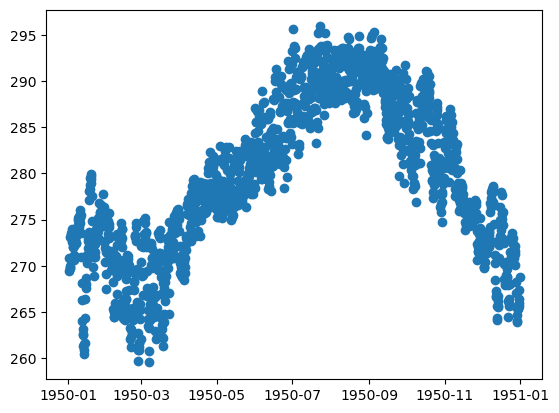

In [34]:
plt.scatter( dsOut.time.values, dsOut.T.values[:,0, 9,19] )

In [37]:
dsOut.T.isel(time=-1).isel(lev=0).values

array([[252.17206, 251.7333 , 251.34238, 251.34322, 251.22368, 251.2504 ,
        251.4103 , 251.84055, 252.2941 , 252.25882, 252.29878, 252.64445,
        253.23573, 253.40298, 253.73723, 254.46571, 255.6412 , 256.3669 ,
        257.66635, 259.0196 , 259.8419 , 257.16843, 255.1915 , 255.42262,
        258.3971 , 262.3281 , 264.58765, 265.05634, 265.9296 , 268.134  ,
        270.24527, 271.8245 , 273.47342, 274.92496, 276.37836, 277.61023,
        278.7157 , 279.47992],
       [249.12465, 248.01701, 247.76497, 248.12355, 248.61679, 249.05807,
        249.77138, 250.42842, 250.48344, 250.02977, 250.42836, 251.07703,
        251.57503, 251.68942, 251.88394, 252.62494, 254.19197, 255.17719,
        256.5661 , 257.97733, 259.20947, 258.8023 , 257.63104, 257.33646,
        258.90057, 261.35196, 263.96332, 264.55875, 265.374  , 266.7286 ,
        268.68042, 270.88452, 272.75784, 274.08823, 275.397  , 276.63504,
        277.7543 , 278.44217],
       [246.76607, 245.34195, 244.63289, 245.22124

In [51]:
# dsBC.time
month=2
ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(
                    time=~ds_month[str(month).zfill(2)].get_index("time").duplicated()).load() #remove any possible duplicate values (and load - BK)
          
ds_month[str(month).zfill(2)].time

<xarray.DataArray 'time' (time: 3616)>
array(['1950-02-01T00:00:00.000000000', '1950-02-01T06:00:00.000000000',
       '1950-02-01T12:00:00.000000000', ..., '1981-02-28T06:00:00.000000000',
       '1981-02-28T12:00:00.000000000', '1981-02-28T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-02-01 ... 1981-02-28T18:00:00

In [31]:
t1=1000; zvar='z'; month=1; k=2
# ds_month[str(month).zfill(2)][zvar].attrs, ds_month[str(month+1).zfill(2)][zvar].attrs
ds_month[str(month).zfill(2)][zvar].values[k,9,19], ds_month[str(month+1).zfill(2)][zvar].values[k,9,19], ds_month[str(month+2).zfill(2)][zvar].values[k,9,19]


(238.11436, 238.11522, 238.11606)

ValueError: x and y must be the same size

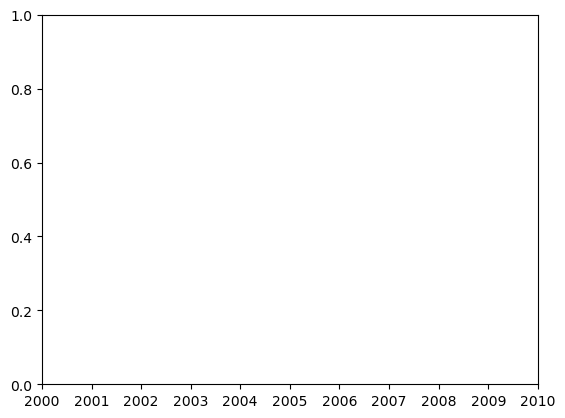

In [36]:
t1=1000; zvar='z'; month=1

plt.scatter(ds_month[str(month).zfill(2)].time.values[:t1], ds_month[str(month).zfill(2)][zvar].values[0,9,19], alpha=.7 )
plt.scatter(ds_month[str(month+1).zfill(2)].time.values[:t1], ds_month[str(month+1).zfill(2)][zvar].values[0,9,19], color='red', alpha=.5 )


In [10]:
for month in range(2,13):
    print(ds_month[str(month).zfill(2)].z.shape)
    print(np.where( ds_month[str(month).zfill(2)].z.values !=  ds_month[str(month-1).zfill(2)].z.values))

(60, 18, 38)
(array([ 0,  0,  0, ..., 59, 59, 59]), array([ 0,  0,  0, ..., 17, 17, 17]), array([11, 14, 28, ..., 35, 36, 37]))
(60, 18, 38)
(array([ 0,  0,  0, ..., 59, 59, 59]), array([ 0,  0,  0, ..., 17, 17, 17]), array([14, 28, 29, ..., 35, 36, 37]))
(60, 18, 38)
(array([ 0,  0,  0, ..., 59, 59, 59]), array([ 0,  0,  0, ..., 17, 17, 17]), array([10, 11, 18, ..., 35, 36, 37]))
(60, 18, 38)
(array([ 0,  0,  0, ..., 59, 59, 59]), array([ 0,  0,  0, ..., 17, 17, 17]), array([ 2, 14, 28, ..., 35, 36, 37]))
(60, 18, 38)
(array([ 0,  0,  0, ..., 59, 59, 59]), array([ 0,  0,  0, ..., 17, 17, 17]), array([ 4, 10, 11, ..., 35, 36, 37]))
(60, 18, 38)
(array([ 0,  0,  0, ..., 59, 59, 59]), array([ 0,  0,  0, ..., 17, 17, 17]), array([ 2, 14, 18, ..., 35, 36, 37]))
(60, 18, 38)
(array([ 0,  0,  0, ..., 59, 59, 59]), array([ 0,  0,  0, ..., 17, 17, 17]), array([ 4, 13, 14, ..., 35, 36, 37]))
(60, 18, 38)
(array([ 0,  0,  0, ..., 59, 59, 59]), array([ 0,  0,  0, ..., 17, 17, 17]), array([ 3,  7,

### Parallel version 
under development (feel free to modify)

In [7]:

def merge_and_save_yr(ds_month, yr, month,
                      out_dir, model, scen):
    t1=time.time()
    dsOut=xr.merge(
        [ds_month[str(month).zfill(2)].sel(
            time=ds_month[str(month).zfill(2)].time.dt.year==yr
        ) for month in range(1,13)]
    ).load()
    print('      merged year '+str(yr) ,' time: ', time.time()-t1)
    t2= time.time()
    dsOut.to_netcdf(out_dir + model+'/'+scen+'/'+model+'_BC_'+str(yr)+'.nc')
    print('      saved year '+str(yr)+' to '+ out_dir + model+'/'+model+'_BC_'+str(yr)+'.nc' 
         ,'time:  ', time.time()-t2)
    

In [ ]:
%%time
Nprocs=8

for mod in range(len(modelLs)):
    for scen in scenarios:

        if not os.path.exists(out_dir + modelLs[mod]+'/'+scen):
                os.makedirs( out_dir + modelLs[mod]+'/'+scen )  

        print(modelLs[mod], scen)

        if scen == "historical":
            year_start = ['1950','1982']
            year_end = ['1981','2014']
        else:
            year_start = ['2015','2047','2079']
            year_end = ['2046','2078','2100']
            
        # load one original GCM file so we can put the variable attributes back:
        dsGCMraw=xr.open_dataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_01.nc")
        

        # for t in range(1): # testing
        for t in range(len(year_start)):
            print(year_start[t], "-", year_end[t])
            ds_month={}

            for month in range(1,13):
            # for month in range(1,2):  # for Testing only
                print('   month = '+str(month).zfill(2))

                # Load the bias corrected dataset
                dsBC=xr.open_mfdataset(mon_BC_path+modelLs[mod]+"/"+scen+'/'+"bias_corrected_"+
                                        year_start[t]+"-"+year_end[t]+"_"+str(month).zfill(2)+".nc")

                # OPTIONAL: put variable attributes back
                for var in dsBC.data_vars:
                    if var != 'z':
                        dsBC[var].attrs = dsRaw[var].attrs
                        # print(dsBC[var].attrs, '\n')

    #             # dsGCMraw=xr.open_dataset(fileGCM[ month - 1])
                # dsGCMraw=xr.open_dataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_"+str(month).zfill(2)+".nc")
    #             # dsBC['time']=dsGCMraw['time'].sel(time=slice(start_time[t], end_time[t])) # what is this??

                dsGroup=dsBC.groupby(dsBC['time'].dt.month).groups
        
                ds_month[str(month).zfill(2)]=dsBC.isel(time=dsGroup[month]) # drop the buffer time periods +/- 15 days

                ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=~ds_month[str(month).zfill(2)].get_index("time").duplicated()) #remove any possible duplicate values
                
                
                # expand the z variable to include time (somehow the bc code removes the time component of z?)
                ds_month[str(month).zfill(2)]['z'] = ds_month[str(month).zfill(2)].z.expand_dims(time=len(ds_month[str(month).zfill(2)].time))
                # ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=slice(start_time[t],end_time[t])).drop('z') # slice and drop z variable - BK:why?
                
   

            # maybe .load() ds_month into memory now?
            # ds_month.load()
                    
            # Merge months and save as yearly datasets (30 yr takes very long/large mem demand).
            print('   loaded datasets, now merge `em')
            with mp.Pool(processes = Nprocs) as p:
                [p.apply( merge_and_save_yr, 
                         args=(ds_month, yr, month, out_dir, modelLs[mod], scen ))
                         for yr in range(int(year_start[t]), int(year_end[t])) ]
            
            del ds_month


## Original code (by Abby)

In [3]:
f1 = '/glade/scratch/abby/ESM_bias_correction/'
f_bias = '/ssp585/three_set/'
f2 = '/glade/scratch/abby/'
f_raw = '/icar_forcing/forcing_by_month/'

varz = ['p','qv','u','v','t']
modelLs=['CESM2','CMCC-CM2-SR5','CNRM-ESM2-1','MIROC-ES2L']
for mod in range(len(modelLs)):
    print(modelLs[mod])

    year_start = ['1950','1955','1960','1965','1970','1975']
    year_end = ['1954','1959','1964','1969','1974','1979']
    start_time=['1950-01-01T12:00:00','1955-01-01T00:00:00','1960-01-01T00:00:00','1965-01-01T00:00:00','1970-01-01T00:00:00','1975-01-01T00:00:00']
    end_time=['1954-12-31T18:00:00','1959-12-31T18:00:00','1964-12-31T18:00:00','1969-12-31T18:00:00','1974-12-31T18:00:00','1979-09-30T18:00:00']
    
    for t in range(len(year_start)):
        print(year_start[t])
        file=sorted(glob.glob('/glade/scratch/abby/ESM_bias_correction/' +modelLs[mod]+ '/ssp585/bias_corrected_'+year_start[t]+'-'+year_end[t]+'_*.nc'))
        fileGCM=sorted(glob.glob(f2 +modelLs[mod]+ f_raw + '*'))
        ds_month={}

        for month in range(1,13):
            print('month = '+str(month))
            i = month - 1
            dsTmp=xr.open_dataset(file[i])
            dsGCMraw=xr.open_dataset(fileGCM[i])
            dsTmp['time']=dsGCMraw['time'].sel(time=slice(start_time[t], end_time[t]))

            dsGroup=dsTmp.groupby(dsTmp['time'].dt.month).groups
            ds_month[str(month).zfill(2)]=dsTmp.isel(time=dsGroup[month]) # drop the buffer time periods +/- 15 days
            ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=~ds_month[str(month).zfill(2)].get_index("time").duplicated()) #remove any possible duplicate values
            ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=slice(start_time[t],end_time[t])).drop('z') # slice and drop z variable

        print('loaded dataset, now merged')
        dsOut=xr.merge([ds_month['01'],ds_month['02'],ds_month['03'],ds_month['04'],ds_month['05'],ds_month['06'],ds_month['07'],ds_month['08'],ds_month['09'],ds_month['10'],ds_month['11'],ds_month['12']])
        print('merged')
        dsOut.to_netcdf('/glade/scratch/abby/ESM_bias_correction/ref_period_only/' + 'bias_corrected_merged_'+modelLs[mod]+'_'+year_start[t]+'-'+year_end[t]+'.nc')
        del ds_month
        del dsOut
        #print('/glade/scratch/abby/ESM_bias_correction/ref_period_only/' + 'bias_corrected_merged_'+modelLs[mod]+'_'+year_start[t]+'-'+year_end[t]+'.nc')

CESM2
1950
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1950-1954.nc
1955
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1955-1959.nc
1960
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1960-1964.nc
1965
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1965-1969.nc
1970
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1970-1974.nc
1975
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1975-1979.nc
CMCC-CM2-SR5
1950
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CMCC-CM2-SR5_1950-1954.nc
1955
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CMCC-CM2-SR5_1955-1959.nc
1960
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CMCC-CM2-SR5_1960-1964.nc
1965
/glade/scratch/abby/ESM_bias_correcti